In [4]:
from learn_structure import bn_example3
from BayesianNetwork import BayesianNetwork
#from StructureLearner.PC import pc
from graphviz import Digraph, Graph, Source
import networkx as nx
from IPython.display import Image
from scipy.stats import beta
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
def kl_divergence(p, q):
    return np.sum(np.where(p != 0, p * np.log(p / q), 0))

In [ ]:
def beta_hist(a,b):
    mean, var, skew, kurt = beta.stats(a, b, moments='mvsk')
    x = np.linspace(beta.ppf(0.001, a, b),
                    beta.ppf(0.999, a, b), 1000)
    y = beta.pdf(x, a, b)
    mod = (a-1)/(a+b-2)
    return x, y, mod

In [ ]:
def plot_beta(a, b, ax, c, label=""):
    if ax is None:
        fig, ax = plt.subplots(1, 1)
    
    x,y,_ = beta_hist(a,b)
    ax.plot(x, y,
           lw=2, alpha=0.6, label=label, color=c)
    
    r = beta.rvs(a, b, size=1000)
    ax.hist(r, density=True, histtype='stepfilled', alpha=0.2, bins=20, color=c)
    ax.legend(loc='best', frameon=False)
    

In [ ]:
plot_beta(100000000+1, 0+1, ax=None, c='b', label="heh")

No handles with labels found to put in legend.


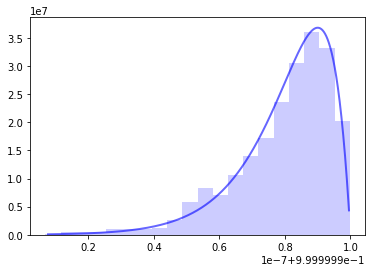

In [57]:
plot_beta(100000000+1, 1+1, ax=None, c='b')

In [39]:
def learn_struc(df):
    G, DiG = pc(df)
    return G, DiG

In [6]:
def effect(ev, on, bn, do_size=200, plot=True):
    # 0
    evidence = {ev:[0]}
    df_do = bn.do(evidence=evidence, size=do_size, seed=12)
    a = len(df_do[df_do[on]==0]) + 1
    b = len(df_do[df_do[on]==1]) + 1
    p = beta_hist(a, b)[2]

    if plot:
        fig, ax = plt.subplots(1, 1, figsize=(8,4))
        plot_beta(a, b, ax, 'r', f"P({on}|{ev}=0)")
        print(f"P({on}=0|{evidence})=", (a-1)/do_size )
        print(f"P({on}=1|{evidence})=", (b-1)/do_size )
        print()
    
    # 1
    evidence = {ev:[1]}
    df_do = bn.do(evidence=evidence, size=do_size, seed=12)
    a = len(df_do[df_do[on]==0]) + 1
    b = len(df_do[df_do[on]==1]) + 1
    q = beta_hist(a, b)[2]

    if plot:
        plot_beta(a, b, ax, 'b', f"P({on}|{ev}=1)")
        plt.tight_layout()
        print(f"P({on}=0|{evidence})=", (a-1)/do_size )
        print(f"P({on}=1|{evidence})=", (b-1)/do_size )
        print()
        
    
    dist = abs(p-q)
    
    if plot:
        print('KL(P||Q) = %1.3f' % dist)
        
    return dist

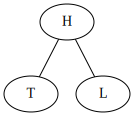

In [5]:
ed = lambda a, b: [f'{a}', f'{b}']

bn = BayesianNetwork([ed("H", "T"), ed("H", "L")])

bn.set_cpd("H", [[0.5], [0.5]], [])

bn.set_cpd("T", [[0.1, 0.8],
                 [0.9, 0.2]], ["H"])

bn.set_cpd("L", [[0.1, 0.9],
                 [0.9, 0.1]], ["H"])

dot = Graph()
dot.edges(bn.G.edges())
dot

In [8]:
bn.get_cpd('H')[1]

,H=1,H=0
0,0.5,0.5


P(H=0|{'L': [0]})= 0.4766666666666667
P(H=1|{'L': [0]})= 0.5233333333333333

P(H=0|{'L': [1]})= 0.4766666666666667
P(H=1|{'L': [1]})= 0.5233333333333333

KL(P||Q) = 0.000


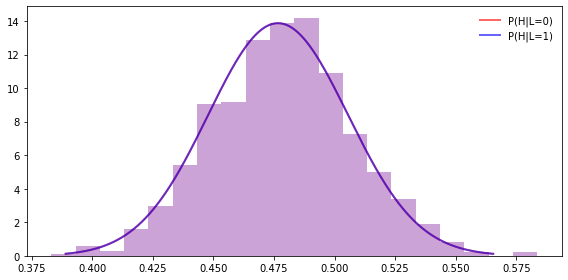

In [8]:
effect(ev="L", on="H", bn=bn, do_size=300, plot=True)
plt.savefig('L_on_H.png')

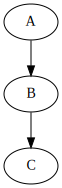

In [9]:
ed = lambda a, b: [f'{a}', f'{b}']

bn = BayesianNetwork([ed("A", "B"), ed("B", "C")])

bn.set_cpd("A", [[0.5], [0.5]], [])

bn.set_cpd("B", [[0.1, 0.8],
                 [0.9, 0.2]], ["A"])

bn.set_cpd("C", [[0.1, 0.9],
                 [0.9, 0.1]], ["B"])

dot = Digraph()
dot.edges(bn.G.edges())
dot

indépendance de niveau : 0
indépendance de niveau : 1
learn V structure
recurssive adding
{('B', 'C'), ('A', 'B'), ('C', 'B'), ('B', 'A')}


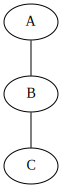

In [11]:
G, dot = learn_struc(bn.sample(100))
dot

P(C=0|{'B': [0]})= 0.91
P(C=1|{'B': [0]})= 0.09

P(C=0|{'B': [1]})= 0.145
P(C=1|{'B': [1]})= 0.855

KL(P||Q) = 0.765


0.765

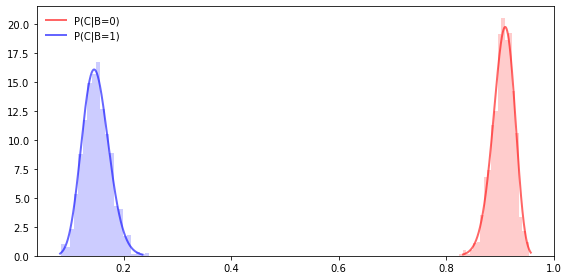

In [13]:
effect(ev="B", on="C", bn=bn)

In [14]:
def orient(G, node1, node2, bn):
    # node1 - node2
    kl1 = effect(ev=node1, on=node2, bn=bn, do_size=100, plot=False)
    kl2 = effect(ev=node2, on=node1, bn=bn, do_size=100, plot=False)
    if kl1>kl2:
        G.add_edge(node1, node2)
    else:
        G.add_edge(node2, node1)

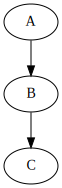

In [15]:
DiG = nx.DiGraph()

for e in G.edges():
    orient(DiG, e[0], e[1], bn)

dot = Digraph()
dot.edges(DiG.edges())
dot

In [9]:
from learn_structure import bn_example2

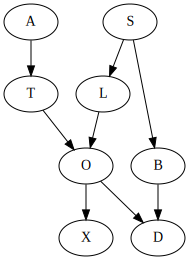

In [10]:
bn = bn_example2()
dot = Digraph()
dot.edges(bn.G.edges())
dot

In [74]:
dataf = bn.get_cpd('O')[1]
dataf

,T,L,O=1,O=0
0,0,0,0.1,0.9
1,0,1,0.0,1.0
2,1,0,0.0,1.0
3,1,1,0.0,1.0


In [103]:
dataf = dataf.set_index(['T', 'L'])

In [77]:
df = pd.DataFrame(data=np.random.randint(2, size=(10,3)), columns=['T', 'L', 'O'])
df

,T,L,O
0,0,0,1
1,0,1,1
2,1,1,0
3,1,1,1
4,0,0,0
5,0,1,0
6,1,1,1
7,1,1,1
8,1,0,1
9,0,1,0


In [69]:
bn

In [108]:
par = ['T', 'L', 'O']
ct = df.reset_index().groupby(par).count()
ct

ValueError: too many values to unpack (expected 2)

In [111]:
for idx in ct.index:
    print(ct.loc[idx][0])
    print(dataf.loc[idx[:-1]])    

1
O=1    0.1
O=0    0.9
Name: (0, 0), dtype: float64
1
O=1    0.1
O=0    0.9
Name: (0, 0), dtype: float64
2
O=1    0.0
O=0    1.0
Name: (0, 1), dtype: float64
1
O=1    0.0
O=0    1.0
Name: (0, 1), dtype: float64
1
O=1    0.0
O=0    1.0
Name: (1, 0), dtype: float64
1
O=1    0.0
O=0    1.0
Name: (1, 1), dtype: float64
3
O=1    0.0
O=0    1.0
Name: (1, 1), dtype: float64


In [38]:
df.set_index(['T','L']).T.columns.names

'T'

In [25]:
df = pd.DataFrame({'month': [1, 4, 7, 10],
                   'year': [2012, 2014, 2013, 2014],
                   'sale': [55, 40, 84, 31]})

In [26]:
df.set_index(['year', 'month'])

,,sale
year,month,
2012,1,55
2014,4,40
2013,7,84
2014,10,31


indépendance de niveau : 0
indépendance de niveau : 1
indépendance de niveau : 2
learn V structure
S->L<-O
X->O<-T
recurssive adding
{('B', 'D'), ('D', 'B'), ('B', 'S'), ('S', 'B')}


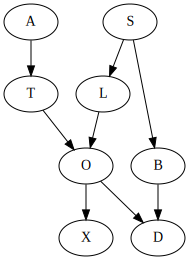

In [48]:
df = pd.read_csv('data/data4.csv')
G, f = learn_struc(df)
f = Graph()
f.edges(G.edges())
dot

In [44]:
list(G.nodes())

['A', 'L', 'S', 'X', 'O', 'B', 'D', 'T']

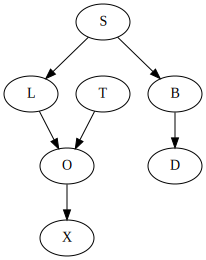

In [46]:
DiG = nx.DiGraph()

for e in G.edges():
    orient(DiG, e[0], e[1], bn)

dot = Digraph()
dot.edges(DiG.edges())
dot

P(L=0|{'O': [0]})= 0.048
P(L=1|{'O': [0]})= 0.952

P(L=0|{'O': [1]})= 0.048
P(L=1|{'O': [1]})= 0.952

KL(P||Q) = 0.000


0.0

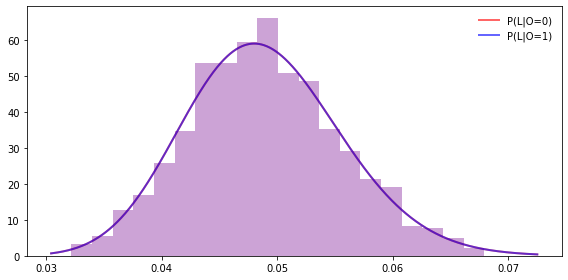

In [34]:
effect(ev="O", on="L", bn=bn, do_size=100)

mod 0: 0.0
P(T=0|{'O': [0]})= 0.0
P(T=1|{'O': [0]})= 1.0

mod 0: 0.0
P(T=0|{'O': [1]})= 0.0
P(T=1|{'O': [1]})= 1.0

KL(P||Q) = 0.000


0.0

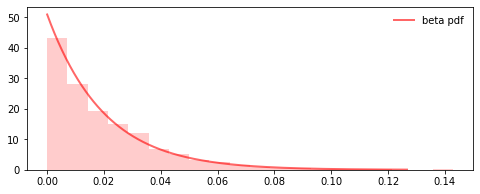

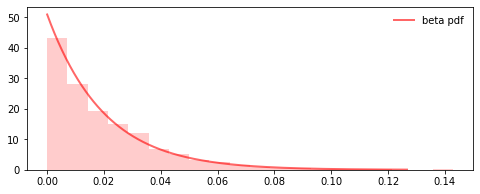

In [82]:
effect(ev="O", on="T", bn=bn, do_size=50)

In [109]:
df = pd.read_csv(f"data/old/1.csv")
for i in range(2, 11):
    if i==4:
        continue
    dfx = pd.read_csv(f"data/old/{i}.csv")
    df = pd.concat((df,dfx))       
    print(len(df))

df = df.drop(['Activity'], axis=1)

519
863
1025
1390
1542
1694
2154
2614


In [112]:
def bn_example2():
    ed = lambda a, b: [f'{a}', f'{b}']

    bn = BayesianNetwork([ed("A", "T"), ed("T", "O"),
                          ed("S", "L"), ed("L", "O"),
                          ed("S", "B"), ed("B", "D"),
                          ed("O", "X"), ed("O", "D")])

    bn.set_cpd("A", [[0.99], [0.01]], [])
    bn.set_cpd("T", [[0.99, 0.95],
                     [0.01, 0.05]], ["A"])
    bn.set_cpd("S", [[0.5], [0.5]], [])
    bn.set_cpd("L", [[0.99, 0.90],
                     [0.01, 0.10]], ["S"])
    bn.set_cpd("B", [[0.7, 0.4],
                     [0.3, 0.6]], ["S"])
    bn.set_cpd("X", [[0.95, 0.02],
                     [0.05, 0.98]], ["O"])
    bn.set_cpd("O", [[0.1, 0.0, 0.0, 0.0],
                     [0.9, 1.0, 1.0, 1.0]], ["T", "L"])
    bn.set_cpd("D", [[0.9, 0.2, 0.3, 0.1],
                     [0.1, 0.8, 0.7, 0.9]], ["O", "B"])

    return bn

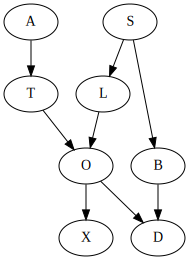

In [114]:
bn = bn_example2()
dot = Digraph()
dot.edges(bn.G.edges())
dot